## Introduction
When new movie released, movie lovers might want to tell how they feel about the movie. On movie review websites, like Rotten Tomatoes, we are able to see either movie critics or normal audience talking about their viewing experience. 

    (Typical moview review format presented on Rotten Tomatoes Website)
<img src="introduction1.png">
<img src="introduction2.png">

For movies to be considered as a worth seeing one, people are usually giving great praise along with a FRESH tomatoes and high rating scores. For movies disappointing, there comes ROTTEN tomatoes and low rating scores.

Sentiment analysis in user generated text contents is helpful for getting feedback of certain movie or product from customers. It is also helpful for analysis of people’s opinions or attitudes to certain event.

### Our Goal
We want to know the relationship between reviews and scores given. In this project, we are going through the sentiment analysis pipeline through several different approaches and explore on real dataset to see the relationship between movie reviews and score given including freshness and rating.

Following topics are covered in this tutorial:
- [Data Collection and Scraping](#Data-collecting-and-preprocessing)
    * [Collect Audience Review From Top Movies](#Collect Audience Review From Top Movies)
    * [Collect Critic Reviews From In-Theater Movie List](#Collect Critic Reviews From In-Theater Movie List)
- [Visualization and cleaning](#Elo-Rating-System)
- [A baseline Approach: Sentiment Lexicons](#K-means-Clustering-algorithm)
- [Machine Learning Aproach: Classification using different classifiers](#K-means-Clustering-algorithm)
- [A Simple Neural Network Approach](#A Simple Neural Network Approach)
- [Summary and references](#Summary-and-references)

## Data Collection and Scraping
For the problem, we collected data from Rotten Tomatoes website (rottentomatoes.com). 

In [3]:
from nltk.corpus import movie_reviews
from bs4 import BeautifulSoup
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For Plotting
import string

In [57]:
rotten_tomatoes = "https://www.rottentomatoes.com"
url_ = "https://www.rottentomatoes.com/m/mad_max_fury_road"

Each critics review on the website includes freshness scores, which can either be fresh or rotten. So it's easy for us to regard 'fresh' as Positive, and 'Rotten' as negative.

In [58]:
def collect_critic_reviews(url):
    """ Scrape Critic reviews on a single movie
    """
    
    critic_reviews_link = url + '/reviews/'

    cr_root = BeautifulSoup(requests.get(critic_reviews_link).text, "html5lib")

    # Get Total Number of Review Pages
    page_total = int(cr_root.find('span', class_='pageInfo').text.split(" ")[3])
    print (page_total)
    
    next_page = critic_reviews_link
    
    # The OutPut
    ret = []

    for i in range(0, page_total):
        tmp_root = BeautifulSoup(requests.get(next_page).text, "html5lib")
        reviews_tab = tmp_root.find(id="reviews")

        reviews = reviews_tab.find_all('div', class_ = 'row review_table_row')
        for review in reviews:
            tmp_dict = {}
            tmp_dict['review'] = review.find('div' ,class_='the_review').text
            tmp_dict['freshness'] = review.find('div', class_='review_icon')['class'][-1]

            ret.append(tmp_dict)
            
        next_page = rotten_tomatoes + reviews_tab.find_all('a', class_='btn')[1].get('href')
        
    return ret

And for audience review, rating score is presented.

In [ ]:
def collect_audience_reviews(url):
    """ Scrape Audience reviews on a single movie
    """
    
    audience_reviews_link = url + '/reviews/?type=user'
    # The OutPut
    ret = []

    cr_root = BeautifulSoup(requests.get(audience_reviews_link).text, "html5lib")

    # Get Total Number of Review Pages
    pageInfo = cr_root.find('span', class_='pageInfo')
    if(pageInfo == None):
        # No Audience Review Yet
        return ret
        
    page_total = int(pageInfo.text.split(" ")[3])
    print (page_total)
    
    next_page = audience_reviews_link # The URL of First Page
    

    for i in range(0, page_total):
        tmp_root = BeautifulSoup(requests.get(next_page).text, "html5lib")
        reviews_div = tmp_root.find(id="reviews")
        reviews_tab = tmp_root.find('div', class_='review_table')

        if(reviews_tab == None):
            break
        
        # Iterate Over Each Review
        reviews = reviews_tab.find_all('div', class_ = 'row review_table_row')
        for review in reviews:
            # Only Take the Review with Rating (5.0)
            fl = review.find('span', class_='fl')
            if(fl != None):
                tmp_dict = {}
                rating = len(fl.find_all('span'))
#                 print (fl.contents[-1])
                if(fl.contents[-1] == "½" or fl.contents[-1] == " ½"):
#                     print ("!!!")
                    rating += 0.5
                tmp_dict['rating'] = rating
                tmp_dict['review'] = review.find('div' ,class_='user_review').text
                ret.append(tmp_dict)
            
        next_page = rotten_tomatoes + reviews_div.find_all('a', class_='btn')[1].get('href')
        
    return ret

### Collect Audience Review From Top Movies
We collect all valid audience reviews from the Top 100 Adventure & Action Movies in history. (Here valid means that each review collected has an rating(0.0 - 5.0) assigned to it.)

In [ ]:
def collect_from_top_list(url, movie_num=100,include_audience=True):
    """
    """
    tl_root = BeautifulSoup(requests.get(url).text, "html5lib")
    table_body = tl_root.find('table', class_='table').tbody
    
    cr_ret = [] # critic_reviews
    ar_ret = [] # audience_reviews
    # Iterate Through the Table
    count = 0
    for tr in table_body.find_all('tr'):
        # Each Movie Link
        movie_link = tr.find_all('td')[2].a.get('href')
        print (count, "Current Movie: ", movie_link)
        print ("Critic Review: ")
        cr_ret += collect_critic_reviews(rotten_tomatoes+movie_link)
        if(include_audience):
            print ("Audience Review: ")
            ar_ret += collect_audience_reviews(rotten_tomatoes+movie_link)

        count += 1
        if(count == movie_num):
            break
    
    if(include_audience):
        return (cr_ret, ar_ret)
    else:
        return cr_ret


In [ ]:
top_100_aa_movies = collect_from_top_list("https://www.rottentomatoes.com/top/bestofrt/top_100_action__adventure_movies/")

Then we apply 'pickle' to load the collected raw data into the 'x.pkl' file, just for easy load afterwards.

In [ ]:
print (len(top_100_aa_movies))
with open('aa_movies_critic_review.pkl', 'wb') as f:
    pickle.dump(top_100_aa_movies[0], f)
with open('aa_movies_audience_review.pkl', 'wb') as f:
    pickle.dump(top_100_aa_movies[1], f)

In [5]:
def load_from_pickle(pickle_path):
    """ Load 'X.pkl' file (List of Dictionaries) to Pandas Data Frame
        Cleaning all Empty Data
    """
    # Read From Pickle File
    with open(pickle_path, 'rb') as f:
        reviews = pickle.load(f, encoding='UTF-8')
    # Load Critic Review into Pandas
    df = pd.DataFrame(reviews)
    print (len(df))
    # Convert Empty String or Blanks to NaN
    df["review"] = df["review"].apply(lambda x : np.nan if isinstance(x, str) and (not x or x.isspace()) else x)
    # Remove Certain Tag
    df['review'] = df['review'].apply(lambda x : str(x).replace('[Full review in Spanish]', ' '))
    df = df[df["review"].notnull()]
    
    return df
    

In [59]:
# Load Top Adventure & Action Reviews
df_aa_ar = load_from_pickle('aa_movies_audience_review.pkl')
df_aa_cr = load_from_pickle('aa_movies_critic_review.pkl')
print (df_aa_ar.dtypes, df_aa_ar['rating'].max(), df_aa_ar['rating'].min() )
unique, counts = np.unique(df_aa_ar['rating'], return_counts=True)
print (unique, counts)

95489
16126
rating    float64
review     object
dtype: object 5.0 0.0
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ] [   12  1334  1103   814  1999  2193  5898  8739 19158 17673 36566]


### Collect Critic Reviews From In-Theater Movie List
We also collect all In-Theater movies' Critic Reviews, considering that the number of 'fresh' and 'rotten' review will be more balanced in this dataset. For example, in those top movie lists, most of them are classical ones with good reputation, meaning more positive reviews will be presented.

The modern web increasing uses front-end frameworks such as AngularJS and React which mean much of the data you might want to extract will not be readily available without rendering the page’s JavaScript.

So we need Selenium here make our crawler look like it’s a real browser instance.


In [60]:
from selenium import webdriver

Also, official driver for browser(we use Chrome here) needs to be downloaded. You can download ChromeDriver here: https://sites.google.com/a/chromium.org/chromedriver/downloads

Then add it either to our path, or put it in the same directory as the notebook or specify the absolute location of it.

In [ ]:
url_it = "https://www.rottentomatoes.com/browse/in-theaters"
driver = webdriver.Chrome('./chromedriver') # Here we just put it under the same directory
driver.get(url_it)

In [ ]:
# Locate 'Show More' Button, then Click on it
try:
    load_more_btn = driver.find_element_by_class_name("mb-load-btn");

except:
    print ("Btn Not Found")
else:
# print (elem)
# # This line will scroll down to make element visible
# driver.execute_script("window.scrollTo(" + load_more_btn.getLocation().x + "," +(load_more_btn.getLocation().y- 100) + ");");
    load_more_btn.click();

# Now Scrape the Page Info
html = driver.page_source
r = BeautifulSoup(html, "html5lib")
all_it_movies = r.find_all('div', class_='mb-movie')
print (len(m))

#### Collection Begin
Then we can launch our scraping process to get all in-theater movies' critic reviews and audience reviews. 

All in-theatre moviews links have to be collected first, by using Selenium described above.

In [ ]:
# URL links to all In-Theatre Movies
it_movie_links = [rotten_tomatoes + m.a.get("href") for m in all_it_movies]

In [ ]:
# Critic Reviews for all In-Theatre Movies
it_critic_reviews = []
for link in it_movie_links:
    it_critic_reviews += collect_critic_reviews(link)
with open('it_critic_reviews.pkl', 'wb') as f:
    pickle.dump(it_critic_reviews, f)
print (len(it_movie_links))

In [ ]:
# Audience Reviews for all In-Theatre Movies
it_audience_reviews = []
for link in it_movie_links:
    it_audience_reviews += collect_audience_reviews(link)
    
print (len(it_audience_reviews))
with open('it_audience_reviews.pkl', 'wb') as f:
    pickle.dump(it_audience_reviews, f)

We also load these raw data to pickle files. And remember to run the cell below if you are interested in running our code.

In [7]:
df_it_cr = load_from_pickle('it_critic_reviews.pkl')
# plt.hist(df_it['freshness'])
df_it_ar = load_from_pickle('it_audience_reviews.pkl')
# df_it_ar

6982
16920


## Visualization and cleaning

In [8]:
# Import Libs
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
from sklearn.metrics import accuracy_score

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords # Stop Words Lists

For critic review dataset, we have two labels: fresh and rotten. We let fresh equivalent to positive, rotten equivalent to negative.

Here we use the In-Theater critic reivew datasets, mainly because that it contains more balanced amount of positive(fresh) and negative(rotten) reviews.

We select 2000 negative reiviews and 2000 positive reviews and put them into different datasets.

Pos Cr:  4952   freshness                                             review
0     fresh   Succeeds as a multi-layered, multi-character ...
1     fresh   The story is energetic enough to sustain so m...
2     fresh   There is plenty of time for huge superhero ba...
4     fresh   "Avengers: Infinity War" is a thrilling, near...
5     fresh   Like any culmination of a long-running series...
Neg Cr:  2030    freshness                                             review
3     rotten   Too many characters, too much plot, too much ...
8     rotten   Avengers: Infinity War has trouble fitting in...
14    rotten   This is why I find the movie's belief that it...
17    rotten   It all amounts to heaps of superhero, everyth...
22    rotten   How long are we going to have to start enduri...
[1] [2000] 2000
[0] [2000] 2000


Text(0.5,1,'In Positive Critic Review Sets')

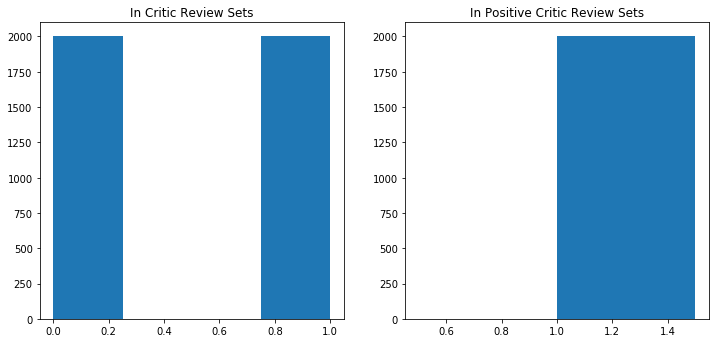

In [71]:
# Generate Fresh & Rotten Data Sets
# df_it_cr['freshness'] = df_it_cr["freshness"].apply(lambda x : 1 if x == 'fresh'  else 0)
cr_pos = df_it_cr[df_it_cr['freshness'] == 'fresh']
cr_neg = df_it_cr[df_it_cr['freshness'] == 'rotten']
print ('Pos Cr: ', len(cr_pos), cr_pos[:5])
print ('Neg Cr: ', len(cr_neg), cr_neg[:5])

# Select 2000 Positive(Fresh) samples and 2000 Negative(Rotten) Samples
X_cr_pos = cr_pos['review'].values[:2000]
y_cr_pos = cr_pos["freshness"].apply(lambda x : 1 if x == 'fresh'  else 0).values[:2000]
unique, counts = np.unique(y_cr_pos, return_counts=True)
print (unique, counts, len(y_cr_pos))

X_cr_neg = cr_neg['review'].values[:2000]
y_cr_neg = cr_neg["freshness"].apply(lambda x : 1 if x == 'fresh'  else 0).values[:2000]
unique, counts = np.unique(y_cr_neg, return_counts=True)
print (unique, counts, len(y_cr_neg))

plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.hist(np.hstack((y_cr_neg, y_cr_pos)), bins = 4)
plt.title("In Critic Review Sets")

plt.subplot(222)
plt.hist(y_cr_pos, bins = 2)
plt.title("In Positive Critic Review Sets")

### Text Processing
The process function is used to do the text processing, in order to generate list of tokens that can be used in next step. First, we acquire tokens from raw text by using tokenizer. Then we remove punctuations and transfer tokens into lemmatized form.

In [11]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    # Generate Tokens From The Input Text
    # 1. To Lower case
    text = text.lower()
    # 2. Deal with Punctuations
    text = text.replace("'s", "")
    text = text.replace("'", "")
    for i in range(0, len(string.punctuation)):
        text = text.replace(string.punctuation[i], ' ')

    # 3. Tokenization 
    tokens = nltk.word_tokenize(text)
    # 4. Convert to Lemmatized Form
    res = []
    for token in tokens:
        try:
            t = lemmatizer.lemmatize(token)
        except:
            continue
        else:
            res.append(t)
            
    return res
    pass

# print (X_it_cr_train[0])
# print (process(X_it_cr_train[0]))

### WordCloud Visualization
After separating the Positive and Negative Critic Reviews, now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative comments.

In [72]:
# Just 'pip install wordcloud'
import wordcloud
from wordcloud import WordCloud,STOPWORDS

Positive Review words


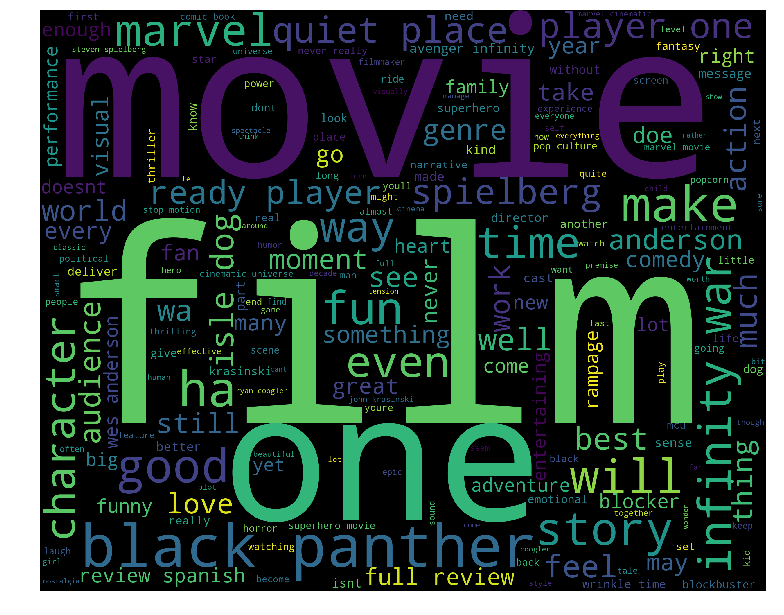

Negative Review words


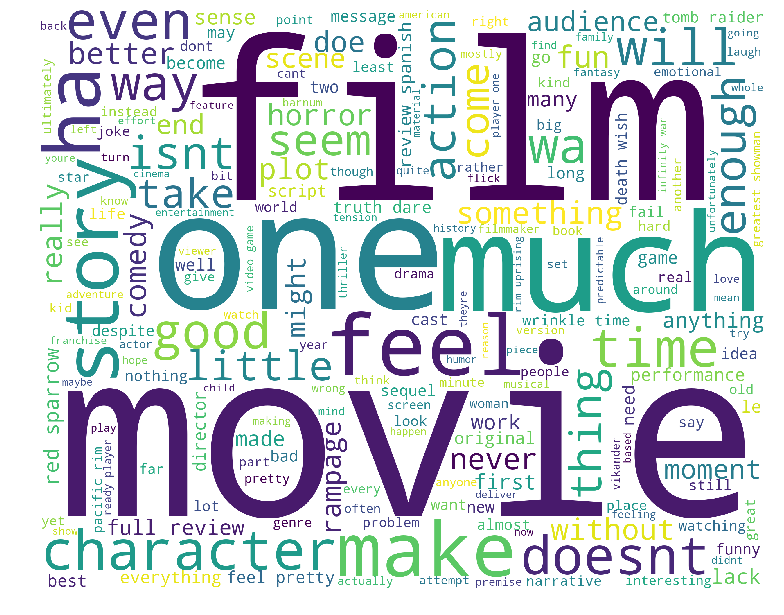

In [73]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    # Text Processing
    cleaned_word = " ".join(process(words))
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive Review words")
wordcloud_draw(X_cr_pos)
print("Negative Review words")
wordcloud_draw(X_cr_neg, 'white')

The two pictures shows the most emphatic words of the reviews with fresh tomatoes and rotten tomatoes respectively, can also be said, positive reviews and negative ones. 

- Both pictures have key words like ‘movie’, ‘film’, ‘one’, etc. These words are usually from sentences that appear frequently when people make comments on the topic. 
- In picture with positive reviews, some positive words can be easily observed, including ‘good’, ‘well’. We can also see that some movies’ names also appear, like ‘Infinity war’, ‘Player one’, which indicates that these movies are always mentioned when people give fresh scores and make compliments on movies. Also, it reveals that high popularity movies may have a larger count of review than other ones.
- In picture with negative reviews, negative words turn up like ‘does not’, ‘horror’, ‘lack’.

Here, For the Audience reviews. Each Review collected is accosiated with a rating(From 0 to 5). Based on all possible rating points(0, 0.5, 1, 1.5 ... 4.5 5), we put all rating points into five slots: 
    
        [0, 0.5] with class label 0
        [1, 1.5] with class label 1
        [2, 2.5] with class label 2
        [3, 3.5] with class label 3
        [4, 4.5] with class label 4
        
And we Combine In-Theater audience reviews with Top Action & Adventure Moview reviews. (Just to make dataset bigger, prepared for later Deep Learning task.)

   rating                                             review
0     2.0    Typical avengers movie. but this time the cg...
1     5.0    Holy crap what a film and a deep one too. Av...
2     1.0    You would think if they were building up to ...
3     5.0    Definitely one of the best MCU movies thus f...
4     4.5                       CAN I EVEN TYPE HERE AT ALL?
95489
16920
112409
[0 1 2 3 4] [ 4426  3956  9950 31632 62445] 112409


(array([ 4426.,  3956.,  9950., 31632., 62445.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

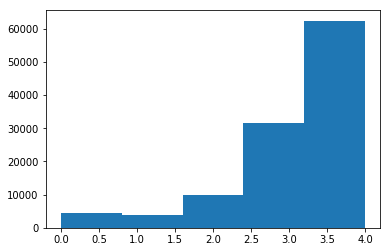

In [13]:
print(df_it_ar.head())
X_it_ar = df_it_ar['review'].values
y_it_ar = df_it_ar['rating'].apply(lambda x : 0 if x == 0 else int((x - 0.5) / 1)).values
X_aa_ar = df_aa_ar['review'].values
y_aa_ar = df_aa_ar['rating'].apply(lambda x : 0 if x == 0 else int((x - 0.5) / 1)).values

X_ar = np.hstack((X_it_ar, X_aa_ar))
y_ar = np.hstack((y_it_ar, y_aa_ar))
# 0 : 0, 0.5, 1
# 1 : 1.5, 2
# 2 : 2.5, 3
# 3 : 3.5, 4
# 4 : 4.5, 5
print (len(X_aa_ar))
print (len(X_it_ar))
print (len(X_ar))
unique, counts = np.unique(y_ar, return_counts=True)
print (unique, counts, len(y_ar))
plt.hist(y_ar, bins = 5)


## A baseline Approach: Sentiment Lexicons

### Using SentiWordnet
One of the most straightforward approaches is to use SentiWordnet: 
* SentiWordNet is a lexical resource for opinion mining. SentiWordNet assigns to each synset of WordNet three sentiment scores: positivity, negativity, objectivity.

to compute the polarity of the words and average that value. The plan is to use this model as a baseline for future approaches.


    Note: The Code below makes use of NLTK's tagging. Basically, tagging is the second step in the typical Natural Language Processing(NLP) pipeline, following tokenization.

    A part-of-speech tagger, or POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word. The 'nltk.pos_tag()' method takes in a sequence of tokens(words), outputs a sequence of tuple: [(word0, TAG0), (word1, TAG1), ...]. For example, tag 'CC' stands for coordinating conjuction, RB for adverbs, IN for preposition, NN for noun and JJ for adjective.

In [80]:
lemmatizer = WordNetLemmatizer()
 
def POST_to_WNT(tag):
    """ Convert between the POS tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
# def clean_text(text):
# #     text = text.replace("<br />", " ")
# #     text = text.decode("utf-8")
 
#     return text
 
def swn_polarity(text):
    """ Return a sentiment polarity: 0 = negative, 1 = positive
    """
 
    sentiment = 0.0
    tokens_count = 0

#     text = clean_text(text)
     # Tokenize Senteces, words; Then Tagging
    raw_sentences = sent_tokenize(text)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
 
        for word, tag in tagged_sentence:
            wn_tag = POST_to_WNT(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # judgment call ? Default to positive or negative
    if not tokens_count:
#         print ("Tokens_count: ", tokens_count)
        return 0
 
    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1

    # negative sentiment
    return 0

Compute the Accuracy of the SWN method (Using the Whole DataSet)

Here we show the prediction accuracy separately, positive and negative.

In [81]:
pred_y_cr_pos = [swn_polarity(doc) for doc in X_cr_pos]
print ('In Theater Moviews Critic Review, Positive Reviews: ', accuracy_score(y_cr_pos, pred_y_cr_pos))
pred_y_cr_neg = [swn_polarity(doc) for doc in X_cr_neg]
print ('In Theater Moviews Critic Review, Negative Reviews: ', accuracy_score(y_cr_neg, pred_y_cr_neg))
print ('In Theater Moviews Critic Review, Summary: ', accuracy_score(np.hstack((y_cr_pos, y_cr_neg)), pred_y_cr_pos+pred_y_cr_neg))


In Theater Moviews Critic Review, Positive Reviews:  0.7535
In Theater Moviews Critic Review, Negative Reviews:  0.3705
In Theater Moviews Critic Review, Summary:  0.562


The SentiWordnet approach produced only a 0.562 accuracy in total(Regarding both negative & positive reviews). In case this figure looks good, keep in mind that in the case of binary classification, 0.5 accuracy is the chance accuracy(just roll the dice...). If the test examples are equally distributed between classes, flipping a coin would yield a 0.5 accuracy. And we can notice that it works alright for positive comments, while performs badly when it comes to negative reviews.

Machine Learning Aproach: Classification using different classifiers

### Naive Bayes classifier
We apply the NLTK NaiveBayes classifier for this part.
(Try to Use this Library Implementation, But it's hard to manipulate. ) So Implement our own version.

For each review, we can define a feature for each word, indicating whether the review document contains that word({wordi : True, wordj : False, ...}).

To limit the number of features that the classifier needs to process, we begin by constructing a list of the words occur more than certain amount of times in the overall corpus( MIN_FREQ ).

The Algorithm: 

- Training Process;
    
      for j ← 1 to class_num do
      
          for i ← 1 to vocab_size do

              count(wi , Cj ) ←number of word wi in sentences of class Cj ;

        end

        count(Cj)  ←number of sentences of class Cj; 
        
        word_count(Cj ) ←number of word in sentences of class Cj ;
  
        P(Cj) ← count(Cj)/∑count(Ci)
        
        end
        
- Predicting Function; 
    * Input: a segmented sentence; 
    * Output: predicted class;

            for j ← 1 to class_num do

                score(j) ← lgP(Cj);

                for i ← 1 to sent_length do

                    score(j) ← score(j) + lg((count(wi, Cj) + 1)/word_count(Cj)+vocab_size)

                end

            end

            Return augmaxj (score(j))

In [82]:
# stopwords.words('english')
# 1. Build Vocabulary
MIN_FREQ = 10

class my_NaiveBayes():
    # Self Implementation (No Library)
    def __init__(self, X, y):

        self.k = len(np.unique(y))
        print ('k (Class Num): ',  self.k)
        self.reverse_dict = dict()
        self.label_cnt = [0 for i in range(self.k + 1)]
        self.label_word_cnt = [0 for i in range(self.k + 1)]
        self.vocab = set()

        # get vocabulary
        tokens_list = []
        for sentence in X:
            tokens_list += process(sentence)
    
        tmp_dict = nltk.FreqDist(tokens_list)
        # Remove Stop Words
        self.vocab = set([key for key, value in tmp_dict.items() if key not in stopwords.words('english') and value > MIN_FREQ])
        self.vocab_size = len(self.vocab)

        
        print ('------ Trainning Begin ------')
        for c in range(0, self.k):
            print ('Class: ', c)
            X_c = X[y==c]
            print (len(X_c))
            # Count Number of class c's Documents
            self.label_cnt[c] += len(X_c)
            self.label_cnt[self.k] += len(X_c)
            
            # Count Word in this class
            tokens_list = []
            for sentence in X_c:
                tokens_list += process(sentence)
    
            tmp_dict = nltk.FreqDist(tokens_list)
        
            for word, cnt in tmp_dict.items():
                if word not in self.vocab:
                    # Word Not Included in Dictionary
                    continue
                else:
                    if word not in self.reverse_dict:
                        self.reverse_dict[word] = [0 for _ in range(self.k + 1)]
                    self.reverse_dict[word][c] += cnt
                    self.reverse_dict[word][self.k] += cnt
                    # Count Total Number of words in Current class's documents
                    self.label_word_cnt[c] += cnt
                    self.label_word_cnt[self.k] += cnt
                    

    # Predict a Single Sentence/Document/Review
    def predict_single_doc(self, sentence):
        score = [1 for i in range(self.k)]

        # 
        for i in range(self.k):
            score[i] += np.log(float(self.label_cnt[i]) / self.label_cnt[self.k])

        for word in process(sentence):
            if word not in self.reverse_dict:
                continue
            for label in range(self.k):
                score[label] += np.log(float(self.reverse_dict[word][label] + 1) /
                                         (self.label_word_cnt[label] + self.vocab_size))

#         return score.index(max(score))
        return np.argmax(score)

    def predict(self, X_te):
        """ Predict a Batch of reviews/documents
        """
#         for doc in X_te:
#             print (type(doc), doc)
        y_pred = [self.predict_single_doc(doc) for doc in X_te]
        
        return y_pred
    

Split into Train, Test(Validation) Sets first. The test set is the 20% of the original dataset. 

Here is the Split of Critic Review Dataset.

In [83]:
X_cr_pos_train, X_cr_pos_test, y_cr_pos_train, y_cr_pos_test = train_test_split(X_cr_pos, y_cr_pos, test_size = 0.2)
X_cr_neg_train, X_cr_neg_test, y_cr_neg_train, y_cr_neg_test = train_test_split(X_cr_neg, y_cr_neg, test_size = 0.2)
print('X_cr_pos_train: ', len(X_cr_pos_train),'X_cr_pos_test: ', len(X_cr_pos_test))
unique, counts = np.unique(y_cr_pos_train, return_counts=True)
print (unique, counts, len(y_cr_pos_train))
print('X_cr_neg_train: ', len(X_cr_neg_train),'X_cr_neg_test: ', len(X_cr_neg_test))
unique, counts = np.unique(y_cr_neg_train, return_counts=True)
print (unique, counts, len(y_cr_neg_train))
# Combine to One Training Set. 1600 Positive Reviews & 1600 Negative Reviews
X_cr_train = np.hstack((X_cr_pos_train, X_cr_neg_train))
y_cr_train = np.hstack((y_cr_pos_train, y_cr_neg_train))
print('X_cr_train: ', len(X_cr_train))
unique, counts = np.unique(y_cr_train, return_counts=True)
print (unique, counts, len(y_cr_train))

# Combine to One Testing Set. 400 Positive Reviews & 400 Negative Reviews
X_cr_test = np.hstack((X_cr_pos_test, X_cr_neg_test))
y_cr_test = np.hstack((y_cr_pos_test, y_cr_neg_test))
print('X_cr_test: ', len(X_cr_test))
unique, counts = np.unique(y_cr_test, return_counts=True)
print (unique, counts, len(y_cr_test))

X_cr_pos_train:  1600 X_cr_pos_test:  400
[1] [1600] 1600
X_cr_neg_train:  1600 X_cr_neg_test:  400
[0] [1600] 1600
X_cr_train:  3200
[0 1] [1600 1600] 3200
X_cr_test:  800
[0 1] [400 400] 800


Then we Split the Whole Audience Review Data into Training Set, Validation Set and Testing Set.

In [ ]:
X_, X_ar_test, y_, y_ar_test = train_test_split(X_ar, y_ar, test_size = 0.1, random_state=0)
X_ar_train, X_ar_cv, y_ar_train, y_ar_cv = train_test_split(X_, y_, test_size = 0.1, random_state=0)

print ('ar_Train: ', len(X_ar_train))
print ('ar_Validation: ', len(X_ar_cv))
print ('ar_Test: ', len(X_ar_test))

ar_Train:  91051
ar_Validation:  10117
ar_Test:  11241


In [ ]:
# build_dictionary(X_it_cr)
nb = my_NaiveBayes(X_cr_train, y_cr_train)
# nb.build_dictionary()
# res = nb.extract_features(X_it_cr, y_it_cr)
# nb.train()
# nb.predict(X_cr_pos_test)
print ('In Theater Movies Critic Review, Positive Reviews: ', accuracy_score(y_cr_pos_test, nb.predict(X_cr_pos_test)))
print ('In Theater Movies Critic Review, Negative Reviews: ', accuracy_score(y_cr_neg_test, nb.predict(X_cr_neg_test)))
print ('In Theater Movies Critic Review, Summary: ',accuracy_score(y_cr_test, nb.predict(X_cr_test)))

# nb_ = my_NaiveBayes(X_ar_train, y_ar_train)
# print ('All Movies Audience Review: ', accuracy_score(y_ar_cv, nb_.predict(X_ar_cv)))


k (Class Num):  2
------ Trainning Begin ------
Class:  0
1600
Class:  1
1600
In Theater Movies Critic Review, Positive Reviews:  0.7225
In Theater Movies Critic Review, Negative Reviews:  0.7475
In Theater Movies Critic Review, Summary:  0.735
k (Class Num):  5
------ Trainning Begin ------
Class:  0
3582
Class:  1
3207
Class:  2
8005
Class:  3
25627


### Support Vector Machine(SVM) Classifier

The implementation is based on libsvm(sklearn.svm.svc: C-Support Vector Classification). The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

The multiclass support is handled according to a one-vs-one scheme.

#### Bag of Words to build vector

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn import svm
from sklearn.linear_model import LogisticRegression

class my_SVM():
# Ignore terms that have a document frequency strictly lower than the given threshold
# Detect and filter stop words
    def __init__(self, use_LR=False, min_df_=10, ngram_range_=(1,3), kernel_='linear'):
        print (' ------ Initializaiton ------')
        self.vectorizer = TfidfVectorizer(min_df=min_df_, ngram_range=ngram_range_, stop_words=stopwords.words('english'))
        if(not use_LR):
            self.clf = svm.SVC(kernel=kernel_, decision_function_shape="ovr") 
        else:
            self.clf = LogisticRegression(solver='sag', multi_class='ovr')

    def train(self, X, y):
        print (' ------ Training Begin ------')
        X_ = self.vectorizer.fit_transform([' '.join(process(doc)) for doc in X])
        print (' ------ TF-IDF Vectorization Finished ------')
        self.clf.fit(X_, y)
        print (' ------ SVM training Finished ------')


    def predict(self, X_te):
        # Transform original documents to (document-term) matrix.
        X_te_ = self.vectorizer.transform([' '.join(process(doc)) for doc in X_te])
        y_pred = self.clf.predict(X_te_)
#         print ('Accuracy: ', accuracy_score(y_te, y_pred))
        unique, counts = np.unique(y_pred, return_counts=True)
        print (unique, counts, len(y_pred))

        return y_pred

In [87]:
# On In Theater Critic Review
my_svm = my_SVM()
my_svm.train(X_cr_train, y_cr_train)

print ('In Theater Movies Critic Review, Positive Reviews: ', accuracy_score(y_cr_pos_test, my_svm.predict(X_cr_pos_test)))
print ('In Theater Movies Critic Review, Negative Reviews: ', accuracy_score(y_cr_neg_test, my_svm.predict(X_cr_neg_test)))
print ('In Theater Movies Critic Review, Summary: ',accuracy_score(y_cr_test, my_svm.predict(X_cr_test)))

 ------ Initializaiton ------
 ------ Training Begin ------
 ------ TF-IDF Vectorization Finished ------
 ------ SVM training Finished ------
[0 1] [108 292] 400
In Theater Movies Critic Review, Positive Reviews:  0.73
[0 1] [313  87] 400
In Theater Movies Critic Review, Negative Reviews:  0.7825
[0 1] [421 379] 800
In Theater Movies Critic Review, Summary:  0.75625


Plot the Critic Review Classification Results.

[0 1] [108 292] 400
[0 1] [313  87] 400
[0 1] [421 379] 800


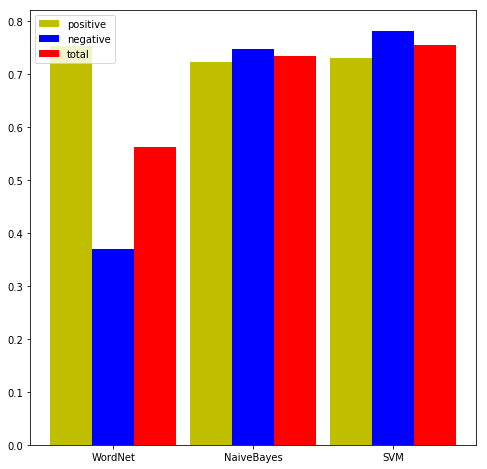

In [88]:
name_list = ['WordNet','NaiveBayes','SVM']
num_list = [accuracy_score(y_cr_pos, pred_y_cr_pos), accuracy_score(y_cr_pos_test, nb.predict(X_cr_pos_test)), accuracy_score(y_cr_pos_test, my_svm.predict(X_cr_pos_test))]
num_list1 = [accuracy_score(y_cr_neg, pred_y_cr_neg), accuracy_score(y_cr_neg_test, nb.predict(X_cr_neg_test)), accuracy_score(y_cr_neg_test, my_svm.predict(X_cr_neg_test))]
num_list2 = [accuracy_score(np.hstack((y_cr_pos, y_cr_neg)), pred_y_cr_pos+pred_y_cr_neg), accuracy_score(y_cr_test, nb.predict(X_cr_test)), accuracy_score(y_cr_test, my_svm.predict(X_cr_test))]

x =list(range(len(num_list)))
total_width, n = 0.9, 3
width = total_width / n

plt.figure(figsize=(8, 8))

plt.bar(x, num_list, width=width, label='positive',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='negative',tick_label = name_list,fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list2, width=width, label='total',fc = 'r')
plt.legend()
plt.show()

### Word embeddings and word2vec

Use Gensim Library here

    pip install --upgrade gensim


In [20]:
import gensim as gs
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Load Google's pre-trained Word2Vec model.
    You can download Google’s pre-trained model here: . It’s 1.5GB before extraction, including word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. And the vector size is 300 features.(Download the file and extract it to your working directory, then run the cell below)

In [15]:
model = gs.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  
# model.wv('marvel')

2018-05-11 17:40:01,742 : INFO : loading projection weights from ./GoogleNews-vectors-negative300.bin
2018-05-11 17:41:37,313 : INFO : loaded (3000000, 300) matrix from ./GoogleNews-vectors-negative300.bin


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA


# Compare Two Vectorization Method
class my_LR():
# Detect and filter stop words
    def __init__(self, use_Embedding=False, min_df_=10, ngram_range_=(1,3), if_preprocess=True, k=10):
        self.use_Embedding = use_Embedding
        self.if_preprocess = if_preprocess
        self.k = k
        self.pca = PCA(n_components = self.k)
#         print (' ------ Initializaiton ------')
        if(not use_Embedding):
            # Ignore terms that have a document frequency strictly lower than the given threshold
            self.vectorizer = TfidfVectorizer(min_df=min_df_, ngram_range=ngram_range_, stop_words=stopwords.words('english'))
        self.clf = LogisticRegression(solver='saga', multi_class='ovr', max_iter=100)

    def train(self, X, y):
#         print (' ------ Training Begin ------')
        if(self.if_preprocess):
            if(self.use_Embedding):
                X_ = self.to_Embedding([gs.utils.simple_preprocess(doc) for doc in X])
    #             X_ = preprocessing.scale(X_)
                # Dimention Reduction
                X_ = self.pca.fit_transform(X_)
            else:
                X_ = self.vectorizer.fit_transform([' '.join(gs.utils.simple_preprocess(doc)) for doc in X])
#                 print (X_.shape)
        else:
            X_ = X
            X_ = self.pca.fit_transform(X_)
            pass
            # The Training Data Has been Preprocessed, No Need to Embedding or TF-IDF Transform
#         print (' ------ Vectorization Finished ------')
        self.clf.fit(X_, y)
#         print (' ------ LR training Finished ------')

    def to_Embedding(self, X):
        """
        """
        tmp = []
        for doc in X:
            vecs = []
            for w in doc:
                try:
                    vecs.append(model.wv[w])
                except KeyError:
                    # Word Not In Vocabulary
                    continue
            if(len(vecs) != 0):
                tmp.append(sum(vecs)/len(vecs))
            else:
                tmp.append(np.random.randn(300))

        # print (len(tmp), tmp[0])
        X_ = np.array(tmp)
#         print (X_.shape)

        return X_

    def predict(self, X_te, test=False):
        # Transform original documents to (document-term) matrix.
        if(not test):
            if(not self.use_Embedding):
                X_te_ = self.vectorizer.transform([' '.join(gs.utils.simple_preprocess(doc)) for doc in X_te])
            else:
                X_te_ = self.to_Embedding([gs.utils.simple_preprocess(doc) for doc in X_te])
                # Dimention Reduction
                X_te_ = self.pca.transform(X_te_)
        else:
            X_te_ = X_te
            X_te_ = self.pca.transform(X_te_)

        y_pred = self.clf.predict(X_te_)

        return y_pred


In [35]:
# 1. Vectorization By TF-IDF
my_lr = my_LR(use_Embedding=False)
my_lr.train(X_ar_train, y_ar_train)

print ('Accuracy: ', accuracy_score(y_ar_test, my_lr.predict(X_ar_test)))# a = to_Embedding(X)

 ------ Initializaiton ------
 ------ Training Begin ------
(91051, 42310)
 ------ Vectorization Finished ------
 ------ LR training Finished ------
[0 1 2 3 4] [ 267   44  370 2538 8022] 11241
Accuracy:  0.6380215283337781


Here we apply PCA first to reduce the dimention of each review document's Embedding Vector(Originally contains 300 features) to k. 

In order to quickly select the best 'k', we preprocessed X_ar_train into X_ first, and modify 'my_LR' model above to make it capable of training Embedding Matrix directly.

In [23]:
X_ = my_LR().to_Embedding([gs.utils.simple_preprocess(doc) for doc in X_ar_train])
print (X_.shape)

 ------ Initializaiton ------


/Users/mac/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(91051, 300)
(91051, 300)


Text(0,0.5,'explained_variance_ratio')

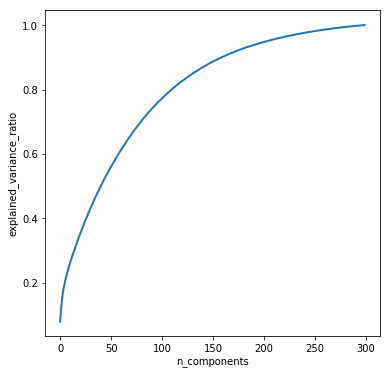

In [30]:
# PCA k spectrum
pca = PCA()
# X_ = my_LR().to_Embedding([gs.utils.simple_preprocess(doc) for doc in X_ar_train])
# print (X_.shape)
pca.fit(X_)
plt.figure(figsize=(6, 6))
plt.clf()
# plt.axes([.2, .2, .7, .7])
# print (pca.explained_variance_ratio_)
variance_by_i = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(0, len(pca.explained_variance_ratio_))]
plt.plot(variance_by_i, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

[1, 6, 11, 16, 21, 27, 32, 37, 42, 47, 53, 58, 63, 68, 73, 79, 84, 89, 94, 100]


/Users/mac/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/mac/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


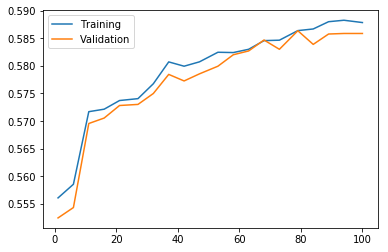

In [56]:
# 2. Vectorization Based on Word Embedding
# my_lr = my_LR(use_Embedding=True, if_preprocess=False)
# my_lr.train(X_, y_ar_train)
# print ('Accuracy: ', accuracy_score(y_ar_test, my_lr.predict(X_ar_test)))# a = to_Embedding(X)
def get_err_k(X, y, X_cv, y_cv, k_):
    # Classification Result Based on Different Size k (Reducted Dimentions)
    my_lr = my_LR(use_Embedding=True, if_preprocess=False, k=k_)
    my_lr.train(X, y)
    return np.array([accuracy_score(y, my_lr.predict(X, test=True)), accuracy_score(y_cv, my_lr.predict(X_cv))])

n_k = [int(x) for x in np.linspace(1, 100, 20)]
print (n_k)
errors = np.array([get_err_k(X_, y_ar_train, X_ar_cv, y_ar_cv, k) for k in n_k])
plt.plot(n_k, errors[:,0], n_k, errors[:,1])
plt.legend(["Training", "Validation"])


## A Simple Neural Network Approach

Deep learning 

The implementation is based on Keras. 

* Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.
  
* Install Keras from PyPI (recommended):
   
       sudo pip install keras
       
* For Installation of TensorFlow Framework, please check [https://www.tensorflow.org/install/install_mac?hl=en#the_url_of_the_tensorflow_python_package]

The whole network is based on some fully connected layers and activation layers (ReLU) layers.

In [ ]:
def to_tokenize(X):
    final_list = []
    for doc in X:
        tmp = []
        for w in doc:
            try:
                tmp.append(word_dict[w])
            except KeyError:
                tmp.append(0)
        final_list.append(tmp)
    return final_list

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout,Embedding,Conv1D,MaxPooling1D,GlobalMaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from keras.preprocessing.sequence import pad_sequences

import keras

class my_DL():
    def __init__(self):
        self.vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,3), stop_words=stopwords.words('english'))
        
    def preprocess(self,texts):
        #self.vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,3), stop_words=stopwords.words('english'))
        #sequences = self.tokenizer.texts_to_sequences(texts)
        X = [process(doc) for doc in texts]
        sequences = to_tokenize(X)
        word_index = word_dict
        vocabulary_size=len(word_index)+1
        embedding_matrix = np.zeros((vocabulary_size, 200))
        for word, i in word_dict.items():
            embedding_vector = model[word]
            embedding_matrix[i] = embedding_vector
        embedding_layer = Embedding(len(embedding_matrix),
                    200,
                    weights=[embedding_matrix],
                    trainable=False)
        data = pad_sequences(sequences, maxlen=500)
        
        return embedding_layer,data    
    def train(self, X, y,is_tfidf=False):
        self.model = Sequential() 
        if is_tfidf:
            X_ = self.vectorizer.fit_transform(X)
        else:
            embedding_layer,X_ = self.preprocess(X)
    
        unique, counts = np.unique(y, return_counts=True)
        num_classes = len(unique)
        y_test = keras.utils.to_categorical(y, num_classes)
        print(X_.shape)
        input_dim = X_.shape[1]
        if is_tfidf is False:
            self.model.add(embedding_layer)
            self.model.add(Conv1D(96, 5, activation='relu'))
            self.model.add(MaxPooling1D(5,3))
            self.model.add(Conv1D(64, 5, activation='relu'))
            self.model.add(MaxPooling1D(5,3))
            self.model.add(Conv1D(48, 5, activation='relu'))
            self.model.add(GlobalMaxPooling1D())
            self.model.add(Dense(units=32, activation='relu'))
            self.model.add(Dense(units=num_classes, activation='softmax'))
        else:
            self.model.add(Dense(units=1024, activation='relu', input_dim=input_dim))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(units=256, activation='relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(units=64, activation='relu'))
            self.model.add(Dense(units=num_classes, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        self.model.fit(X_, y_test, epochs=5, batch_size=128)

    def predict(self, X_te, y_te,is_tfidf=False):
        # Transform original documents to (document-term) matrix.
        if is_tfidf:
            X_te_ = self.vectorizer.transform(X_te)
        else:
            X_te = [process(doc) for doc in X_te]
            sequences_te = to_tokenize(X_te)
            #sequences_te = self.tokenizer.texts_to_sequences(X_te)
            X_te_ = pad_sequences(sequences_te, maxlen=500)
        y_pred = self.model.predict(X_te_,batch_size=128)
        print(y_pred.shape)
        y_pred = np.argmax(y_pred,axis=1)
        print ('Accuracy: ', accuracy_score(y_te, y_pred))

        return y_pred

In [76]:
my_dl = my_DL()
my_dl.train(X_cr_train, y_cr_train)

Now we can try to view all four methods' performance on critic review dataset.(Positive or Negative Binary classification)

    Note: we have to apologize that the graph below was attached instead of the direct result of the cell, because our environment brokes(TensorFlow Framework) while we editing the final notebook version.

In [78]:
name_list = ['WordNet','NaiveBayes','SVM', 'Neural Network']
num_list = [accuracy_score(y_cr_pos, pred_y_cr_pos), accuracy_score(y_cr_pos_test, nb.predict(X_cr_pos_test)), accuracy_score(y_cr_pos_test, my_svm.predict(X_cr_pos_test)), accuracy_score(y_cr_pos_test, my_dl.predict(X_cr_pos_test))]
num_list1 = [accuracy_score(y_cr_neg, pred_y_cr_neg), accuracy_score(y_cr_neg_test, nb.predict(X_cr_neg_test)), accuracy_score(y_cr_neg_test, my_svm.predict(X_cr_neg_test)), accuracy_score(y_cr_neg_test, my_dl.predict(X_cr_neg_test))]
num_list2 = [accuracy_score(np.hstack((y_cr_pos, y_cr_neg)), pred_y_cr_pos+pred_y_cr_neg), accuracy_score(y_cr_test, nb.predict(X_cr_test)), accuracy_score(y_cr_test, my_svm.predict(X_cr_test)), accuracy_score(y_cr_test, my_dl.predict(X_cr_test))]

x =list(range(len(num_list)))
total_width, n = 1.2, 3
width = total_width / n

plt.figure(figsize=(8, 8))

plt.bar(x, num_list, width=width, label='positive',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='negative',tick_label = name_list,fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list2, width=width, label='total',fc = 'r')
plt.legend()
plt.show()

<img src="final_result.jpg">

# Summary and references

### Summary and future work
In this project, we apply SentiWordnet, machine learning approach and deep learning approach on crawled movie reviews. 
    
- For critical reviews, we find that our neutral network model does not outperform other approaches, in that dataset is not large enough and model can be tuned in future. 

- On the other hand, 'easy' solution like SVM and Naive Bayes are able to yield stable results in most cases, espeically in the Audience Review Classification task.

### references
1. Data analytics have made the NBA unrecognizable: https://qz.com/1104922/data-analytics-have-revolutionized-the-nba/
2. Exploring Golden State Warriors with Data Science: http://blog.thedevmasters.com/blog/exploring-nba-data-python
3. Official NBA Stats: https://stats.nba.com
4. Elo Rating System: https://en.wikipedia.org/wiki/Elo_rating_system
5. K-means Clustering: https://en.wikipedia.org/wiki/K-means_clustering
6. sklearn KMeans document: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict